# Autoencoders for Nonlinear Dimension Reduction

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 15 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*

## Introduction

In our journey through statistical machine learning techniques, we've explored Principal Component Analysis (PCA) as a powerful method for linear dimension reduction. PCA revealed how astronomical data, despite its apparent high dimensionality, often contains intrinsic structure that can be captured in far fewer dimensions. However, the universe rarely confines itself to linear relationships. From the complex spectral variations in stellar atmospheres to the intricate morphological features of galaxies, astronomical phenomena frequently exhibit nonlinear patterns that linear methods struggle to capture.

Autoencoders represent a natural evolution in our dimension reduction toolkit, extending the conceptual framework of PCA while relaxing its restrictive assumption of linearity. Both PCA and autoencoders share the same fundamental objective: minimizing reconstruction error when projecting data to lower dimensions. The crucial difference lies in their approach—where PCA is constrained to linear transformations, autoencoders employ neural networks to discover nonlinear transformations. This fundamental shift—from linear algebra to nonlinear function approximation—opens new possibilities for understanding complex astronomical datasets.

The motivation for nonlinear dimension reduction becomes particularly clear when we consider the physical processes that generate astronomical data. Stellar spectra, for instance, depend nonlinearly on temperature, pressure, and chemical composition through complex radiative transfer processes. Galaxy morphologies form intricate manifolds in image space, shaped by nonlinear gravitational dynamics and star formation feedback. These nonlinear relationships mean that the most informative low-dimensional representations may require curved, rather than flat, projections through the data space.

At its core, an autoencoder implements a simple yet powerful idea: compress data through a bottleneck and then reconstruct it. The architecture consists of two neural networks working in tandem. The encoder network $c(\mathbf{x})$ transforms high-dimensional inputs into a compact latent representation $\mathbf{z}$, while the decoder network $f(\mathbf{z})$ reconstructs the original data from this compressed form. By training these networks jointly to minimize reconstruction error, the autoencoder discovers nonlinear features that capture the essence of the data.

This bottleneck architecture serves a crucial purpose beyond mere compression. Just as PCA's constraint to find orthogonal directions forces it to identify independent modes of variation, the autoencoder's bottleneck forces it to identify the most essential features for reconstruction. The resulting latent representations often reveal physically meaningful patterns—morphological types in galaxy images, evolutionary stages in stellar spectra, or phase relationships in variable star light curves.

The applications of autoencoders in astronomy extend well beyond dimension reduction. Their ability to separate structured signals from random noise makes them valuable for denoising astronomical observations. Their sensitivity to reconstruction anomalies enables outlier detection in large surveys. Perhaps most intriguingly, the encoder-decoder framework can be generalized to create mappings between different data domains, enabling us to bridge gaps between simulations and observations or to integrate multi-wavelength data into unified representations.

## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Neural Networks**: Understanding of fully connected layers, activation functions, forward propagation, and backpropagation
- **PyTorch Basics**: Experience with tensor operations, automatic differentiation, and model training workflows
- **Linear Algebra**: Comfort with matrix operations, eigendecomposition, and the mathematical foundations of PCA
- **Chapter 15 Material**: The theoretical foundations of autoencoders, including their relationship to PCA and the mathematical formulation of reconstruction loss

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Implementation**: Building autoencoder architectures in PyTorch, understanding the encoder-decoder structure and the role of the bottleneck layer
- **Training Dynamics**: Monitoring training and test losses, recognizing overfitting patterns, and implementing early stopping through model checkpointing
- **Latent Space Analysis**: Visualizing and interpreting the learned representations in the bottleneck layer, understanding how they capture data structure
- **Reconstruction Quality**: Evaluating the trade-offs between compression ratio and reconstruction fidelity, comparing with linear methods like PCA
- **Practical Considerations**: Managing small datasets, understanding the limitations of MSE loss for image reconstruction, and recognizing when nonlinear methods provide advantages over PCA

We begin by importing the necessary libraries and configuring our computational environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

%matplotlib inline

Using device: cpu


## Understanding the Data: Galaxy Images from Modern Surveys

As in our PCA tutorial, we work with galaxy images from the Hyper Suprime-Cam (HSC) survey. This dataset provides an ideal testbed for comparing linear and nonlinear dimension reduction techniques. While PCA revealed that galaxy morphology could be efficiently encoded using linear combinations of eigen-galaxies, autoencoders offer the potential to capture more subtle nonlinear relationships in the data.

The same preprocessing steps have been applied:
- **Standardization**: 64×64 pixel cutouts centered on each galaxy
- **Normalization**: Pixel values scaled to [0, 1] range

Each image represents 4,096 dimensions in our feature space. The challenge for autoencoders is to discover nonlinear transformations that compress this information more efficiently than PCA's linear projections. The potential advantage lies in capturing curved relationships—for instance, how spiral arm tightness might vary nonlinearly with galaxy mass, or how bulge profiles transition smoothly but nonlinearly between different galaxy types.

In [2]:
# Load the galaxy image dataset
galaxy_images = np.load('dataset_images_galaxy.npy')

# Verify data dimensions
print(f"Dataset shape: {galaxy_images.shape}")
print(f"Number of galaxies: {galaxy_images.shape[0]}")
print(f"Pixels per image: {galaxy_images.shape[1]}")
print(f"Image dimensions: {int(np.sqrt(galaxy_images.shape[1]))} × {int(np.sqrt(galaxy_images.shape[1]))}")

# Basic statistics
print(f"\nPixel statistics:")
print(f"Min value: {np.min(galaxy_images):.3f}")
print(f"Max value: {np.max(galaxy_images):.3f}")
print(f"Mean value: {np.mean(galaxy_images):.3f}")
print(f"Std deviation: {np.std(galaxy_images):.3f}")

Dataset shape: (1500, 4096)
Number of galaxies: 1500
Pixels per image: 4096
Image dimensions: 64 × 64

Pixel statistics:
Min value: 0.000
Max value: 0.899
Mean value: 0.065
Std deviation: 0.105


Before diving into the autoencoder implementation, let's visualize our galaxy dataset. The visualization function below mirrors the one from our PCA tutorial, allowing direct comparison between the two approaches. Understanding the diversity of galaxy morphologies in our sample—from smooth ellipticals to grand-design spirals—will help us appreciate what features the autoencoder learns to encode.

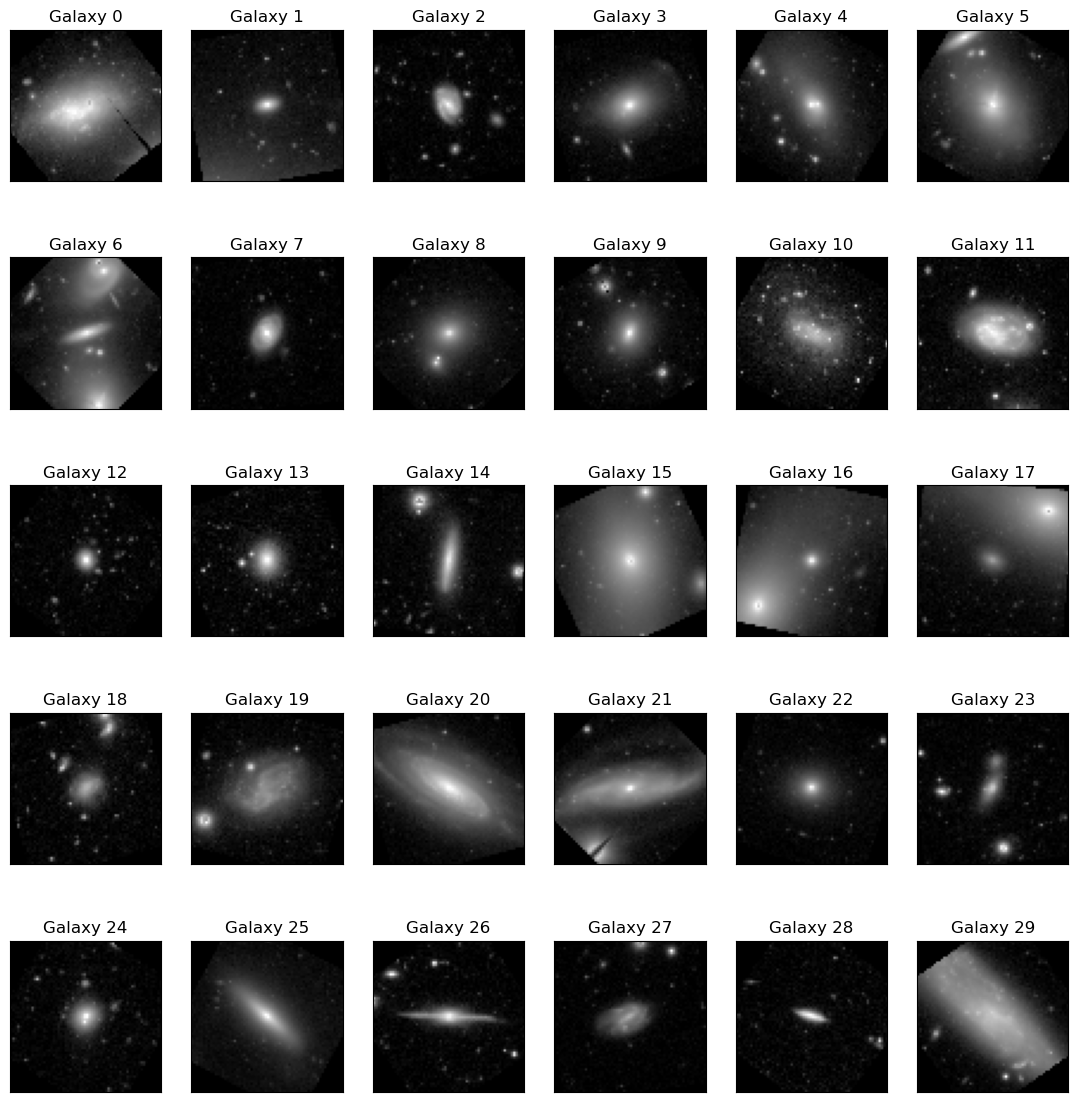

In [3]:
def plot_gallery(images, titles, h, w, n_row=2, n_col=6):
    """
    Plot a gallery of images.
    
    Parameters:
    -----------
    images : numpy.ndarray
        Each row is a flattened image.
    titles : list
        Titles for each subplot.
    h : int
        Image height in pixels.
    w : int
        Image width in pixels.
    n_row : int
        Number of rows in the gallery.
    n_col : int
        Number of columns in the gallery.
    """
    # Assert to make sure we have enough images and titles for the grid
    assert len(images) >= n_row * n_col
    assert len(titles) >= n_row * n_col
    
    # Initialize the plot
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    
    # Loop to populate the gallery
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        # Reshape the flattened image data to 2D and plot it
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        
        # Add title and remove axis ticks
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        
    plt.show()

# Display a sample of galaxy images
plot_gallery(galaxy_images, [f"Galaxy {i}" for i in range(30)], 64, 64, 5, 6)

## The Autoencoder Architecture

The galaxy images reveal the rich morphological diversity in our sample—from compact elliptical galaxies with smooth light distributions to extended spiral galaxies with complex substructure. Where PCA would seek linear combinations of pixel values to represent these variations, autoencoders can learn nonlinear transformations that potentially capture more nuanced relationships between morphological features.

### Mathematical Framework

Following the notation from Chapter 15, we implement an autoencoder consisting of:

1. **Encoder**: $c(\mathbf{x}): \mathbb{R}^{4096} \rightarrow \mathbb{R}^{32}$
2. **Decoder**: $f(\mathbf{z}): \mathbb{R}^{32} \rightarrow \mathbb{R}^{4096}$

The reconstruction process follows:
$$\hat{\mathbf{x}} = f(c(\mathbf{x}))$$

where we minimize the mean squared error between input and reconstruction:
$$\mathcal{L} = \frac{1}{N}\sum_{n=1}^N \|\mathbf{x}_n - f(c(\mathbf{x}_n))\|^2$$



### Network Design

Our architecture employs a symmetric design with progressively narrowing layers in the encoder and expanding layers in the decoder. This hourglass structure forces the network to discover efficient representations while maintaining sufficient capacity for accurate reconstruction. We use ReLU activation functions throughout, providing the nonlinearity that distinguishes autoencoders from PCA while avoiding the vanishing gradient issues associated with sigmoid activations.

The choice of 32 latent dimensions allows meaningful compression while retaining enough capacity to capture galaxy morphological diversity. This represents a compression ratio of 128:1, more aggressive than our PCA applications.

In [4]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder: c(x)
        self.encoder = nn.Sequential(
            nn.Linear(4096, 512),   # Layer 1: Compress from image space to intermediate representation
            nn.ReLU(),              # Nonlinear activation
            nn.Linear(512, 128),    # Layer 2: Further compression
            nn.ReLU(),              
            nn.Linear(128, 32),     # Layer 3: Final compression to latent space
            nn.ReLU()               
        )
        
        # Decoder: f(z)
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),     # Layer 1: Begin expansion from latent space
            nn.ReLU(),              
            nn.Linear(128, 512),    # Layer 2: Continue expansion
            nn.ReLU(),              
            nn.Linear(512, 4096)    # Layer 3: Reconstruct to original image dimensions
        )
    
    def forward(self, x):
        z = self.encoder(x)         # Encode: z = c(x)
        x_hat = self.decoder(z)     # Decode: x_hat = f(z)
        return x_hat

# Instantiate the model and move to appropriate device
model = AutoEncoder().to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
encoder_params = sum(p.numel() for p in model.encoder.parameters())
decoder_params = sum(p.numel() for p in model.decoder.parameters())

print(f"Total parameters: {total_params:,}")
print(f"Encoder parameters: {encoder_params:,}")
print(f"Decoder parameters: {decoder_params:,}")

Total parameters: 4,338,976
Encoder parameters: 2,167,456
Decoder parameters: 2,171,520


## Training the Autoencoder

With our architecture defined, we turn to the training process. Unlike PCA's closed-form solution via eigendecomposition, autoencoders require iterative optimization through gradient descent. This iterative nature, while computationally more demanding, allows the network to discover complex nonlinear relationships that would be impossible to capture analytically.

### Data Preparation and Train-Test Split

A critical consideration when training neural networks is overfitting—the tendency for models to memorize training data rather than learning generalizable patterns. This risk is particularly acute with our relatively small dataset of 1,500 galaxy images. To monitor and mitigate overfitting, we split our data into training (80%) and test (20%) sets.

The test set serves as a proxy for unseen data, allowing us to track whether our autoencoder is learning meaningful compression strategies or simply memorizing the training examples. As we'll see, the divergence between training and test losses provides crucial insight into when to stop training.

### Optimization Strategy

We employ the Adam optimizer, which adapts learning rates for each parameter based on historical gradients. This adaptive approach often converges faster than standard gradient descent, particularly important given the high dimensionality of our parameter space. The mean squared error (MSE) loss aligns with our mathematical formulation and provides a clear signal for reconstruction quality.

Mini-batch training strikes a balance between computational efficiency and gradient stability. By computing gradients over batches of 64 images rather than the entire dataset, we introduce beneficial noise that can help escape local minima while maintaining reasonable convergence properties.

In [5]:
# Prepare data for PyTorch
dataset = TensorDataset(torch.tensor(galaxy_images, dtype=torch.float32))
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training configuration
learning_rate = 1e-3
n_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_function = nn.MSELoss()

# Storage for tracking training progress
train_losses = []
test_losses = []
best_test_loss = float('inf')
best_model_state = None

print(f"Training samples: {train_size}")
print(f"Test samples: {test_size}")
print(f"Batch size: {batch_size}")
print(f"Total training batches: {len(train_loader)}")

Training samples: 1200
Test samples: 300
Batch size: 64
Total training batches: 19


Epoch [10/200] - Train Loss: 0.002347, Test Loss: 0.002107
Epoch [20/200] - Train Loss: 0.001758, Test Loss: 0.001709
Epoch [30/200] - Train Loss: 0.001577, Test Loss: 0.001610
Epoch [40/200] - Train Loss: 0.001462, Test Loss: 0.001561
Epoch [50/200] - Train Loss: 0.001360, Test Loss: 0.001520


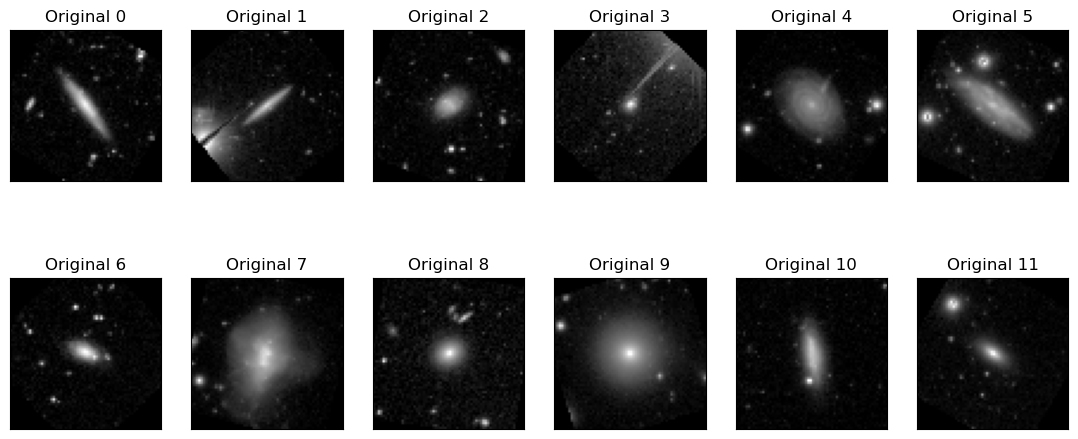

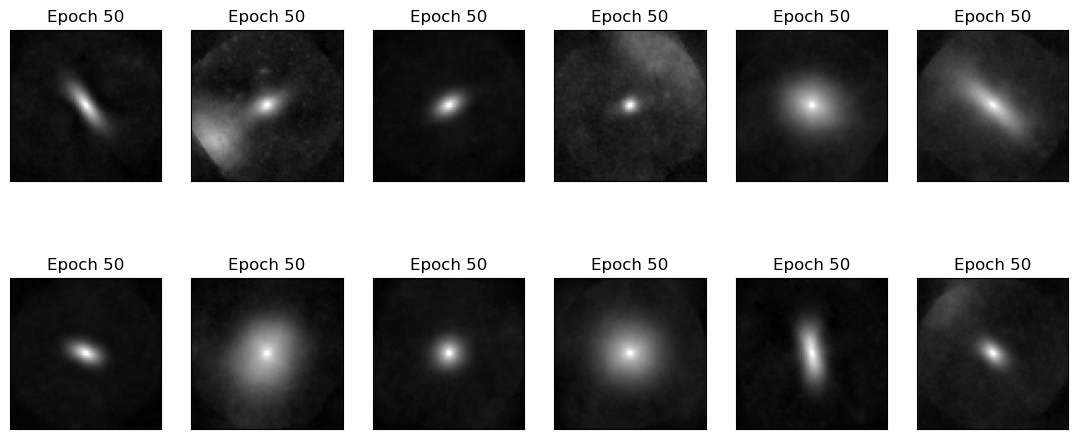

Epoch [60/200] - Train Loss: 0.001293, Test Loss: 0.001527
Epoch [70/200] - Train Loss: 0.001244, Test Loss: 0.001532
Epoch [80/200] - Train Loss: 0.001189, Test Loss: 0.001530
Epoch [90/200] - Train Loss: 0.001171, Test Loss: 0.001550
Epoch [100/200] - Train Loss: 0.001109, Test Loss: 0.001530


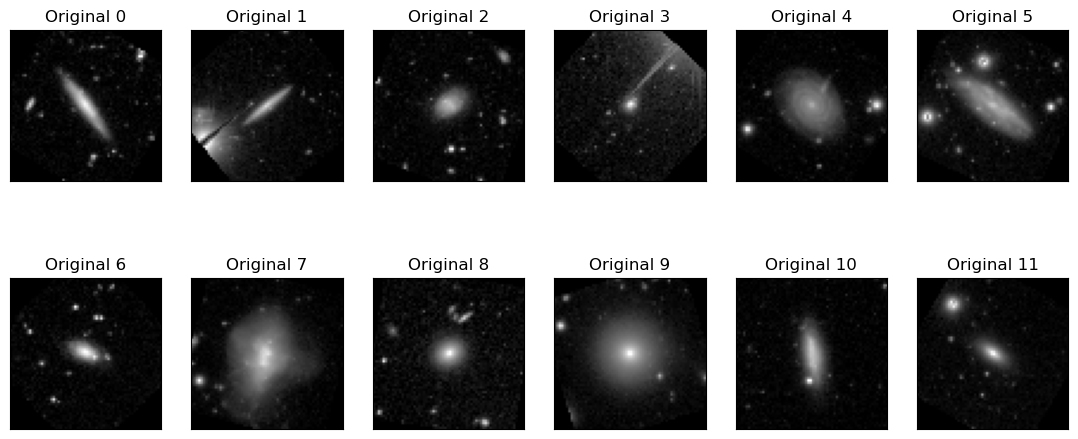

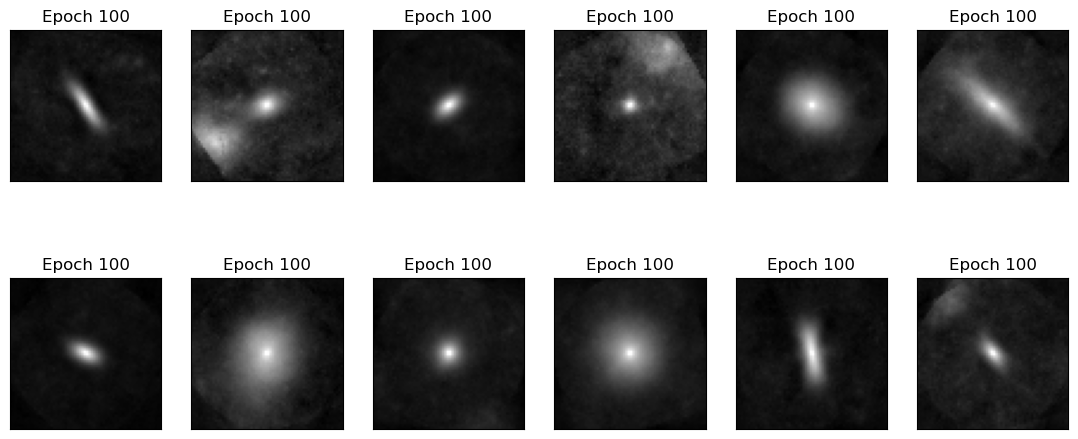

Epoch [110/200] - Train Loss: 0.001063, Test Loss: 0.001527
Epoch [120/200] - Train Loss: 0.001034, Test Loss: 0.001545
Epoch [130/200] - Train Loss: 0.001020, Test Loss: 0.001581
Epoch [140/200] - Train Loss: 0.001046, Test Loss: 0.001601
Epoch [150/200] - Train Loss: 0.000948, Test Loss: 0.001584


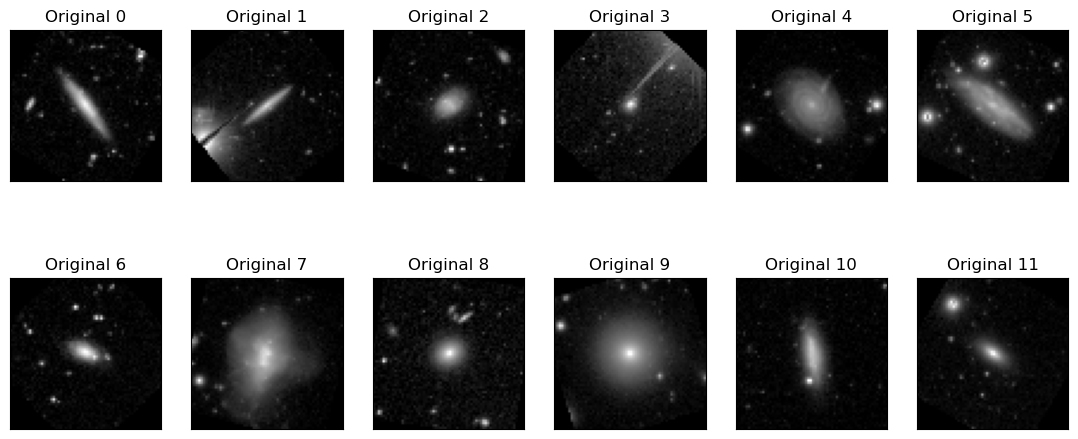

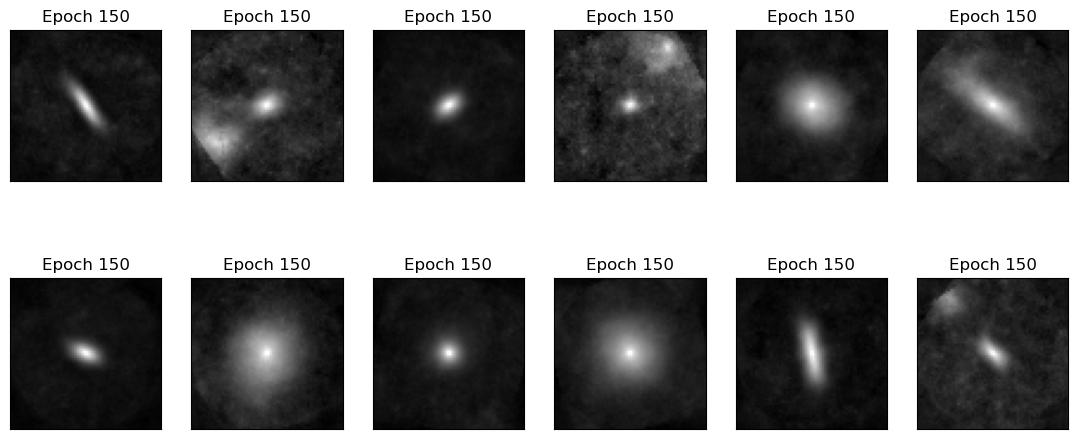

Epoch [160/200] - Train Loss: 0.000946, Test Loss: 0.001606
Epoch [170/200] - Train Loss: 0.000937, Test Loss: 0.001629
Epoch [180/200] - Train Loss: 0.000895, Test Loss: 0.001625
Epoch [190/200] - Train Loss: 0.000872, Test Loss: 0.001624
Epoch [200/200] - Train Loss: 0.000865, Test Loss: 0.001648


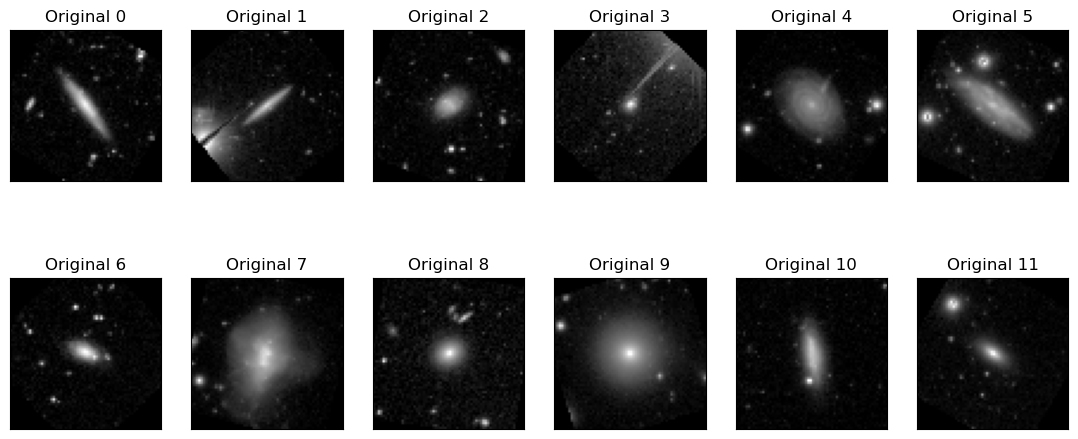

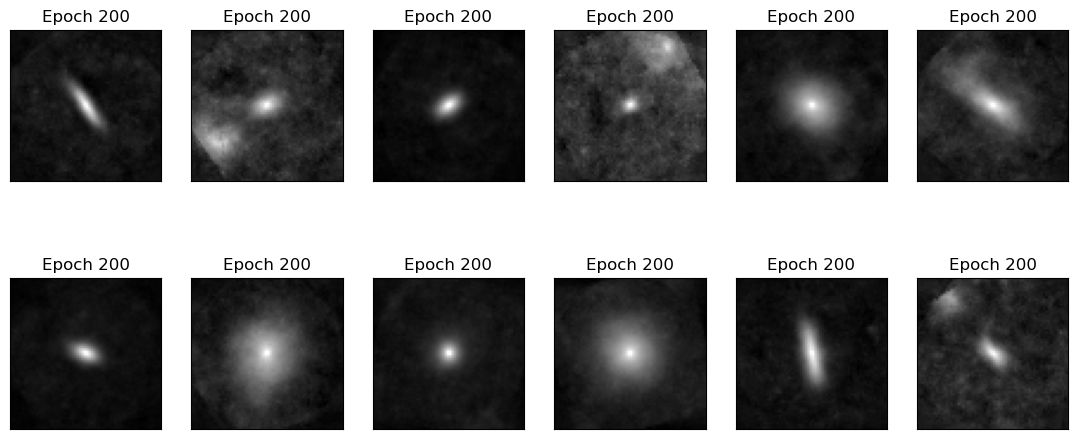

In [6]:
# Training loop
for epoch in range(n_epochs):
    # Training phase
    model.train()
    epoch_train_losses = []
    
    for batch in train_loader:
        # Forward pass
        x = batch[0].to(device)
        x_hat = model(x)
        loss = loss_function(x_hat, x)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_losses.append(loss.item())
    
    # Test phase
    model.eval()
    epoch_test_losses = []
    
    with torch.no_grad():
        for batch in test_loader:
            x = batch[0].to(device)
            x_hat = model(x)
            test_loss = loss_function(x_hat, x)
            epoch_test_losses.append(test_loss.item())
    
    # Calculate average losses
    avg_train_loss = np.mean(epoch_train_losses)
    avg_test_loss = np.mean(epoch_test_losses)
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    
    # Save best model based on test loss
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_state = model.state_dict().copy()
    
    # Progress reporting
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}] - Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
    
    # Visualize reconstructions periodically
    if (epoch + 1) % 50 == 0:
        model.eval()
        with torch.no_grad():
            sample_batch = next(iter(test_loader))[0][:12].to(device)
            reconstructed = model(sample_batch)
            
            # Display original and reconstructed images
            plot_gallery(sample_batch.cpu().numpy(), 
                        [f'Original {i}' for i in range(12)], 
                        64, 64, 2, 6)
            plot_gallery(reconstructed.cpu().numpy(), 
                        [f'Epoch {epoch+1}' for i in range(12)], 
                        64, 64, 2, 6)

By examining the evolution of training and test losses, we can understand the network's learning trajectory and identify the critical point where memorization begins to dominate generalization.

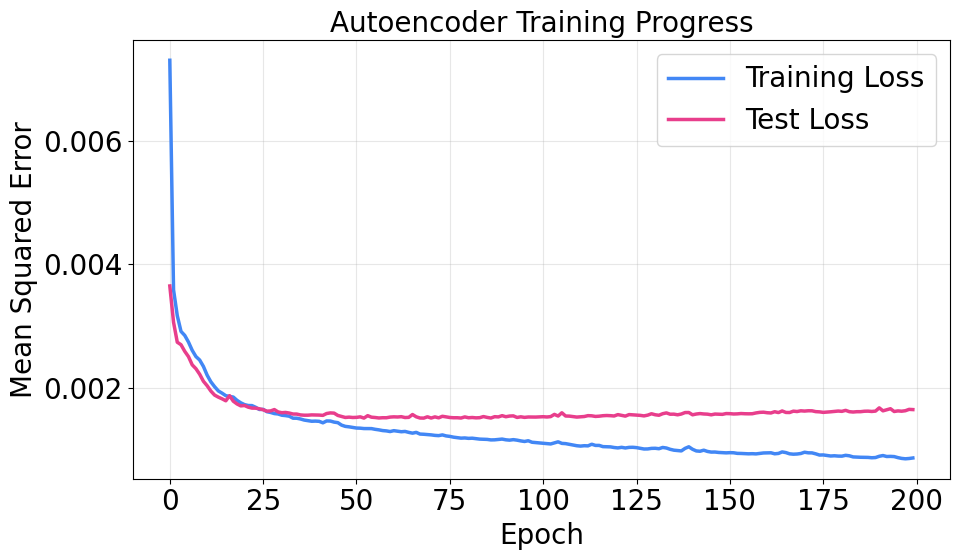

Best test loss: 0.001510 at epoch 69
Final training loss: 0.000865
Final test loss: 0.001648


In [7]:
# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', linewidth=2.5, color='#4287f5')
plt.plot(test_losses, label='Test Loss', linewidth=2.5, color='#e83e8c')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Autoencoder Training Progress')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Find epoch with minimum test loss
best_epoch = np.argmin(test_losses) + 1
print(f"Best test loss: {best_test_loss:.6f} at epoch {best_epoch}")
print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final test loss: {test_losses[-1]:.6f}")

The training curves illustrate the characteristic behavior of neural network optimization on a limited dataset. Both losses decrease rapidly in the initial epochs as the network learns the primary patterns in galaxy morphology. However, after approximately 25-50 epochs, the trajectories diverge: while training loss continues its gradual descent, the test loss plateaus and even shows slight increases.

This divergence signals overfitting—the network has transitioned from learning generalizable morphological features to memorizing specific training examples. The gap between training and test losses quantifies this memorization effect. For our galaxy dataset, the network achieves its best generalization around epoch 40-50, after which additional training primarily improves performance on training data without corresponding benefits for unseen galaxies.

The relatively small magnitude of both losses (around 0.001-0.002) indicates successful reconstruction overall. However, the persistent gap between training and test performance reminds us that with limited data, neural networks can easily overfit. This motivates our practice of saving the model state at the point of lowest test loss rather than after complete training.

Test Set Reconstructions:


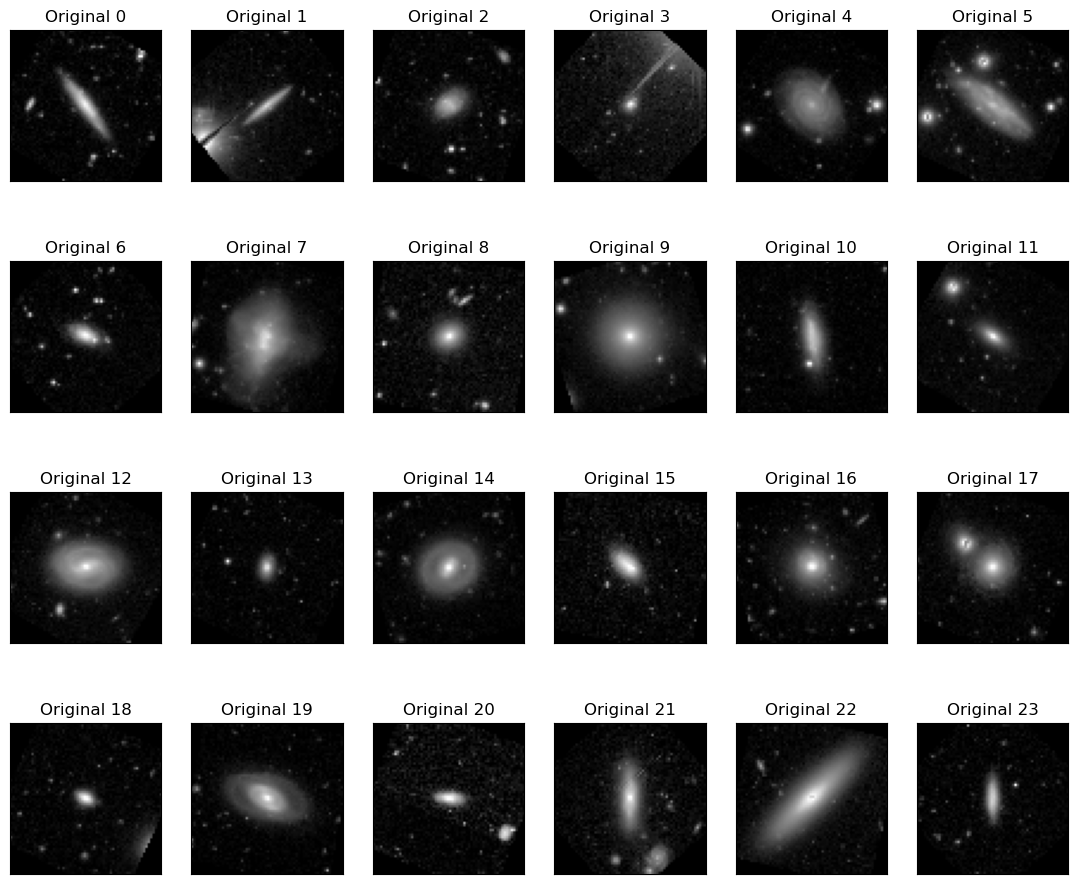

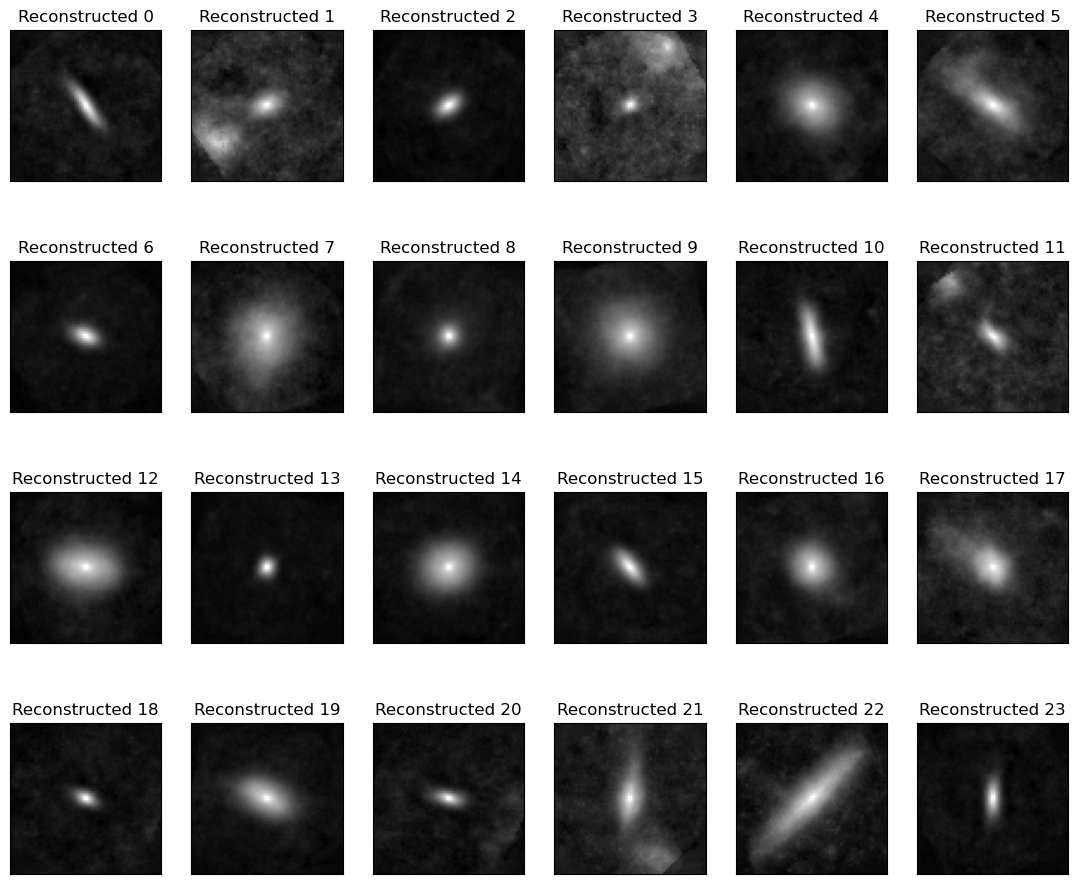


Reconstruction MSE - Test: 0.001429, Train: 0.000829


In [8]:
# Load the best model state
model.load_state_dict(best_model_state)
model.eval()

# Generate reconstructions from test set
with torch.no_grad():
    # Get a batch of test images
    test_batch = next(iter(test_loader))[0].to(device)
    test_reconstructed = model(test_batch)
    
    # Also get a batch of training images for comparison
    train_batch = next(iter(train_loader))[0].to(device)
    train_reconstructed = model(train_batch)

# Display test set reconstructions
print("Test Set Reconstructions:")
plot_gallery(test_batch[:24].cpu().numpy(), 
            [f'Original {i}' for i in range(24)], 
            64, 64, 4, 6)
plot_gallery(test_reconstructed[:24].cpu().numpy(), 
            [f'Reconstructed {i}' for i in range(24)], 
            64, 64, 4, 6)

# Calculate reconstruction errors
test_mse = nn.MSELoss()(test_reconstructed, test_batch).item()
train_mse = nn.MSELoss()(train_reconstructed, train_batch).item()
print(f"\nReconstruction MSE - Test: {test_mse:.6f}, Train: {train_mse:.6f}")

## Analyzing Reconstruction Quality

The reconstructions demonstrate the autoencoder's ability to capture galaxy morphology using just 32 latent dimensions—a compression ratio of 128:1. Remarkably, these results are achieved with a training set of only 1,200 galaxies, a relatively small dataset for deep learning applications. Several patterns emerge from examining these results:

**Morphological Preservation**: Despite the limited training data, the autoencoder successfully preserves the primary morphological features of each galaxy. Edge-on systems maintain their characteristic elongated profiles. Face-on spirals retain their overall structure, while elliptical galaxies preserve their smooth, centrally concentrated light distributions.

**Denoising Effect**: The reconstructions appear smoother than the originals, with background noise and faint companion objects largely removed. This isn't surprising—the bottleneck forces the network to prioritize the dominant galaxy signal over random pixel variations. Small background sources and noise fluctuations lack the coherent structure needed for efficient encoding through the compressed representation.

**Loss of Fine Details**: While overall morphology is preserved, subtle features are simplified. Spiral arm details, faint outer regions, and small-scale structure within galaxies become smoothed. This represents the trade-off inherent in aggressive compression—the network learns to encode the features that best minimize average reconstruction error across the limited training dataset.

**Comparison with PCA**: With 32 components, these autoencoder reconstructions show improved fidelity compared to PCA using similar compression levels. The nonlinear transformations allow the autoencoder to better capture the curved relationships in galaxy morphology—how bulge and disk components combine, how spiral patterns wind, and how brightness profiles vary with galaxy type. This advantage persists even with our modest dataset size, suggesting that the nonlinear approach efficiently exploits the available training examples.



## Exploring the Latent Space

Having established that our autoencoder achieves good reconstruction quality, we now investigate what the network has learned to encode in its 32-dimensional latent space. Unlike PCA's principal components, which we can directly visualize as eigen-galaxies, the autoencoder's latent dimensions emerge through the optimization process and may encode complex, nonlinear features.

To understand these learned representations, we can probe the decoder by constructing specific latent vectors and observing what galaxies they generate. By activating individual latent dimensions while keeping others at zero, we can visualize what each dimension contributes to the reconstruction. This approach reveals how the network has organized its compressed representation space.

Since our encoder applies ReLU activation to the latent layer, all latent values are non-negative. We can therefore explore the effect of each dimension by creating latent vectors of the form $(0, 0, ..., \alpha, ..., 0)$ where $\alpha > 0$ activates a single dimension. By varying $\alpha$, we observe how strongly activating each feature affects the generated galaxy morphology.

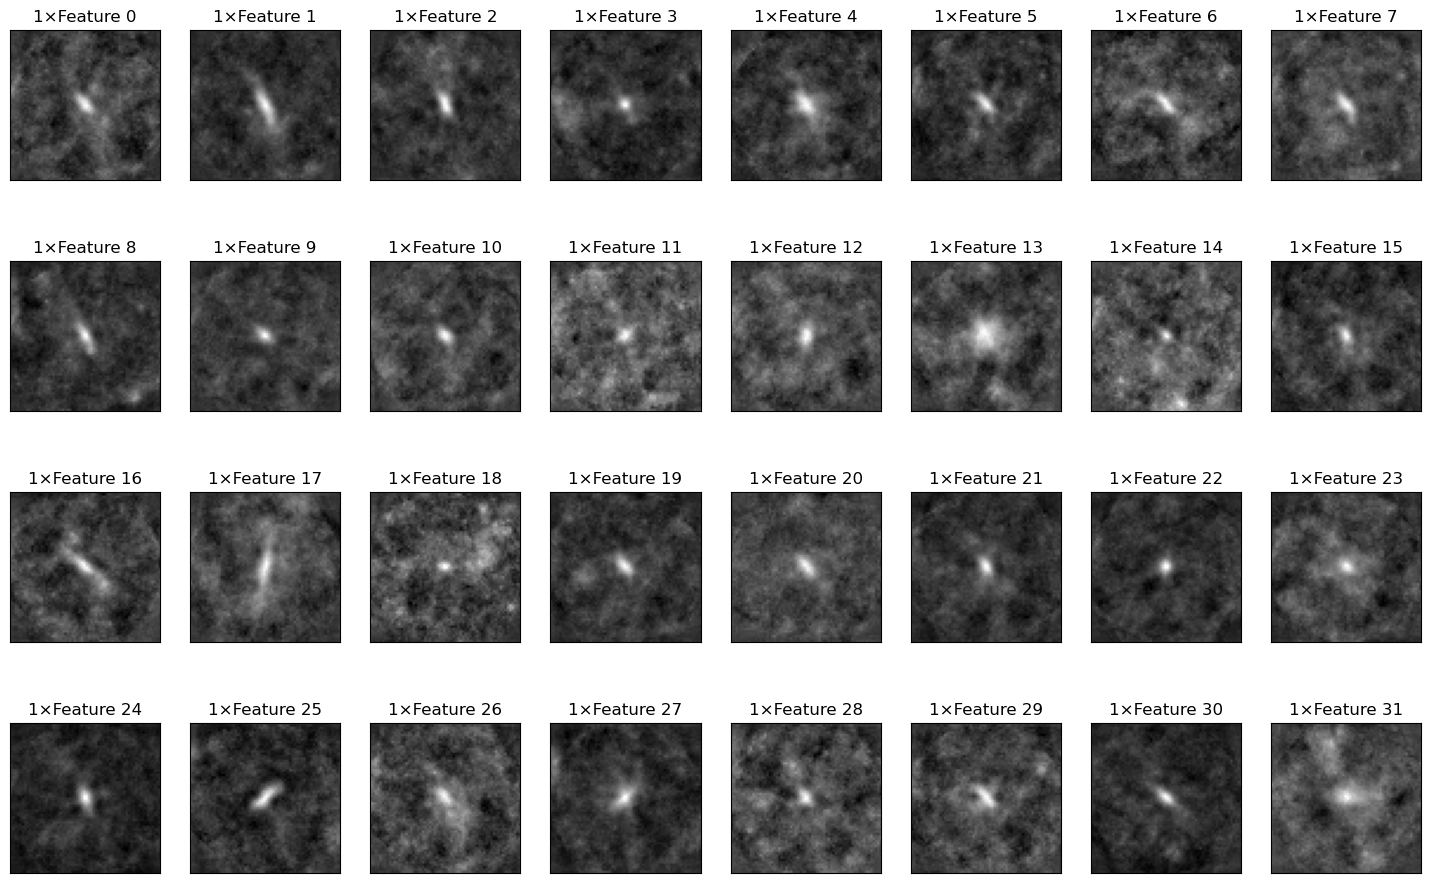

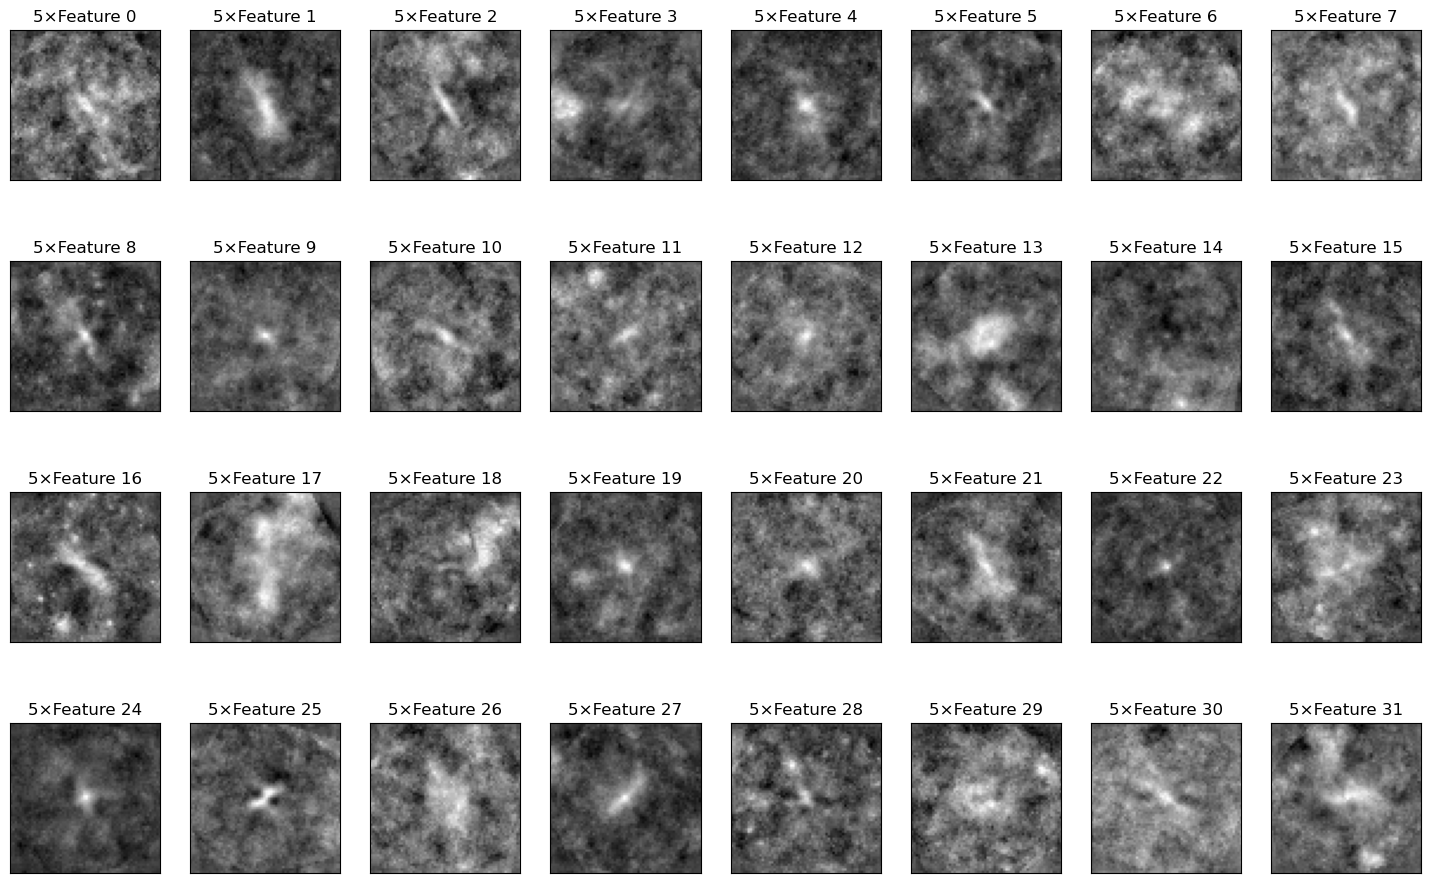

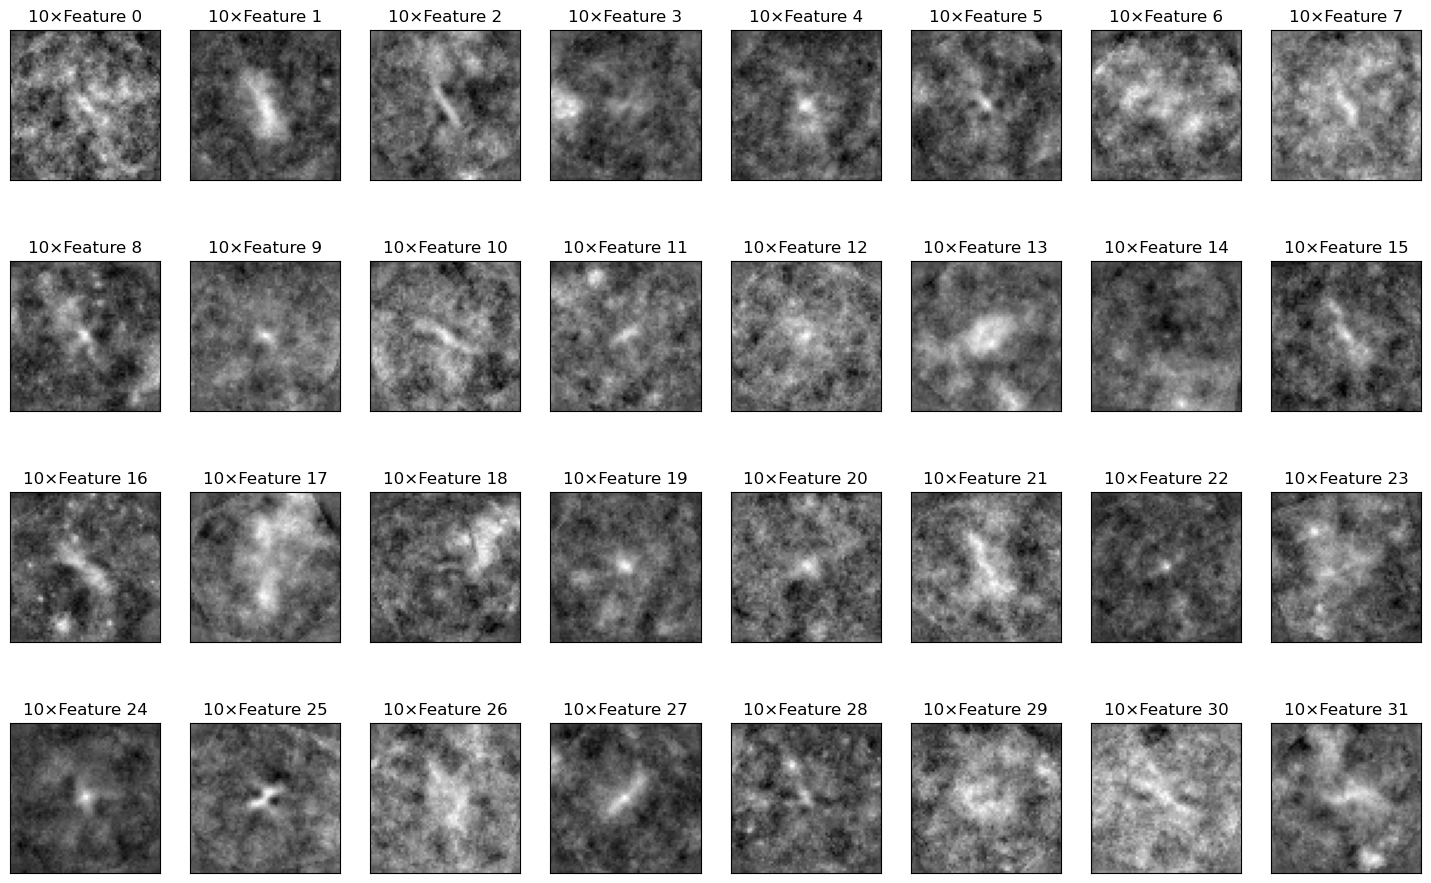

In [9]:
# Explore individual latent dimensions
num_latent_dims = 32

# Create latent vectors that activate single dimensions
for scale in [1, 5, 10]:
    # Create identity matrix scaled by the factor
    latent_codes = scale * torch.eye(num_latent_dims).to(device)
    
    # Decode these latent vectors
    with torch.no_grad():
        generated = model.decoder(latent_codes)
    
    # Visualize the generated galaxies
    plot_gallery(generated.cpu().numpy(), 
                [f'{scale}×Feature {i}' for i in range(num_latent_dims)], 
                64, 64, 4, 8)

The latent feature visualizations reveal how the autoencoder has organized its 32-dimensional representation space. Several observations emerge from examining these generated galaxies:

**Feature Specialization**: Different latent dimensions have learned to encode distinct morphological characteristics. Some features generate edge-on disk galaxies with varying inclination angles, while others produce more face-on spiral or elliptical morphologies. This specialization emerges naturally from the training process—the network discovers that separating different galaxy orientations into different latent dimensions helps minimize reconstruction error.

**Nonlinear Activation Effects**: Unlike PCA where scaling a component linearly scales its contribution, the autoencoder exhibits nonlinear behavior. The 1× activations produce relatively clean galaxy morphologies, while 5× and 10× activations become increasingly noisy rather than simply more pronounced. This occurs because the decoder was trained on latent representations within a specific range—those produced by encoding actual galaxies. When we artificially push single dimensions to extreme values, we venture into regions of latent space the decoder rarely encountered during training, resulting in less coherent outputs.

**Distributed Representation**: Unlike PCA where each component must be orthogonal to others, the autoencoder's features can share some characteristics. Multiple features might generate similar edge-on galaxies, likely encoding subtle variations in disk thickness, bulge prominence, or inclination angle. This redundancy allows for more flexible representation of the continuous parameter space of galaxy morphologies.



## Beyond Reconstruction: The Power of Learned Representations

While our autoencoder may not dramatically outperform PCA in reconstruction error with limited training data, the learned representations offer capabilities that extend beyond simple dimension reduction. The nonlinear encoding allows for more complex operations in the latent space and enables applications that would be difficult or impossible with linear methods.

### Interpolation in Latent Space

One advantage of autoencoder representations is the ability to perform meaningful interpolations between galaxies. By encoding two galaxies and interpolating between their latent representations, we can generate a smooth morphological transition that often corresponds to physically plausible intermediate states.

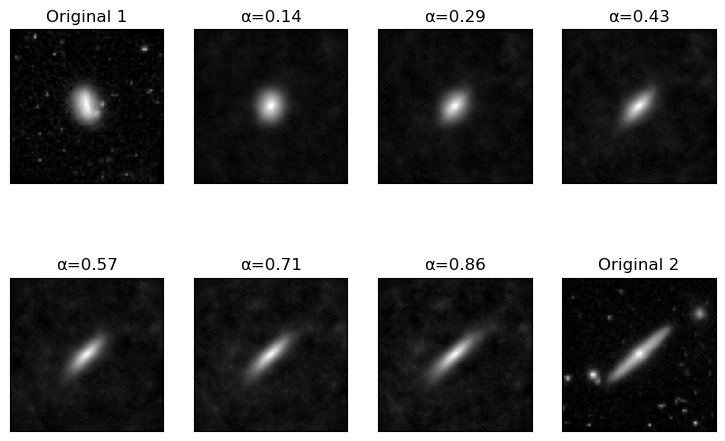

In [10]:
# Select two galaxies with different morphologies for interpolation
idx1, idx2 = 50, 150  # Indices chosen to show morphological diversity

# Encode the selected galaxies
model.eval()
with torch.no_grad():
    galaxy1 = torch.tensor(galaxy_images[idx1:idx1+1], dtype=torch.float32).to(device)
    galaxy2 = torch.tensor(galaxy_images[idx2:idx2+1], dtype=torch.float32).to(device)
    
    z1 = model.encoder(galaxy1)
    z2 = model.encoder(galaxy2)
    
    # Create interpolation steps
    n_steps = 8
    interpolated_galaxies = []
    
    # Add original galaxy 1
    interpolated_galaxies.append(galaxy_images[idx1:idx1+1])
    
    # Add interpolated galaxies
    for i in range(1, n_steps-1):
        alpha = i / (n_steps - 1)
        z_interp = (1 - alpha) * z1 + alpha * z2
        galaxy_interp = model.decoder(z_interp)
        interpolated_galaxies.append(galaxy_interp.cpu().numpy())
    
    # Add original galaxy 2
    interpolated_galaxies.append(galaxy_images[idx2:idx2+1])

# Visualize the interpolation
interpolated_galaxies = np.vstack(interpolated_galaxies)
titles = ['Original 1'] + [f'α={i/(n_steps-1):.2f}' for i in range(1, n_steps-1)] + ['Original 2']
plot_gallery(interpolated_galaxies, titles, 64, 64, 2, 4)

The interpolation reveals how the autoencoder has learned to organize galaxy morphologies in its latent space. The transition from one galaxy to another follows a smooth path, with intermediate states showing gradual changes in morphological features. This smooth interpolation suggests that the autoencoder has discovered a continuous representation where nearby points in latent space correspond to similar galaxy appearances.



### Anomaly Detection Through Reconstruction Error

Another practical application of autoencoders lies in identifying unusual or anomalous galaxies. Since the autoencoder learns to reconstruct typical galaxies from the training distribution, objects with unusual morphologies often produce higher reconstruction errors. This property makes autoencoders useful for discovering rare astronomical objects or identifying data quality issues.

By examining which galaxies are poorly reconstructed, we can identify objects that deviate from the typical morphological patterns in our training set. These might include galaxies with unusual features, merging systems, or even artifacts in the data. Let's examine the reconstruction quality for potential anomalies:

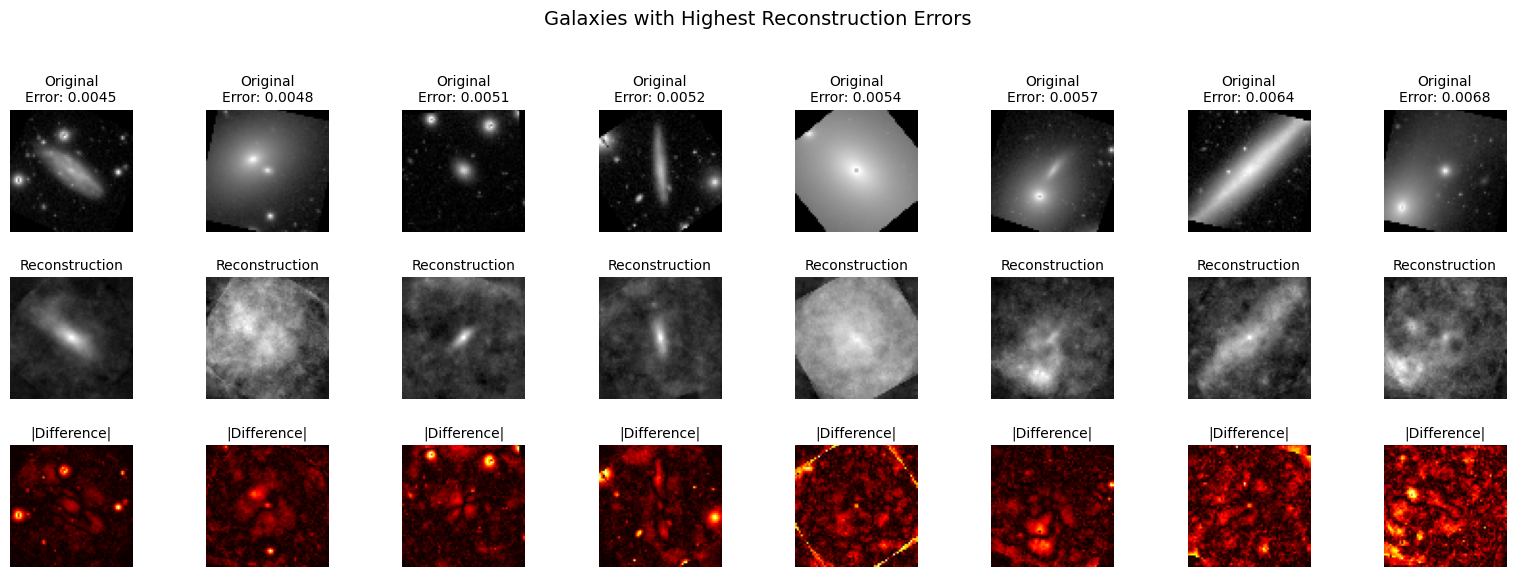

In [11]:
# Calculate reconstruction errors for all galaxies
model.eval()
reconstruction_errors = []
all_reconstructions = []

with torch.no_grad():
    for i in range(0, len(galaxy_images), batch_size):
        batch = torch.tensor(galaxy_images[i:i+batch_size], dtype=torch.float32).to(device)
        reconstructed = model(batch)
        
        # Calculate per-galaxy MSE
        batch_errors = torch.mean((batch - reconstructed)**2, dim=1)
        reconstruction_errors.extend(batch_errors.cpu().numpy())
        all_reconstructions.append(reconstructed.cpu().numpy())

reconstruction_errors = np.array(reconstruction_errors)
all_reconstructions = np.vstack(all_reconstructions)

# Find galaxies with highest reconstruction errors
anomaly_indices = np.argsort(reconstruction_errors)[-8:]  # Top 8 highest errors

# Create figure showing original, reconstruction, and difference
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

for i, idx in enumerate(anomaly_indices):
    # Original image
    axes[0, i].imshow(galaxy_images[idx].reshape(64, 64), cmap='gray')
    axes[0, i].set_title(f'Original\nError: {reconstruction_errors[idx]:.4f}', fontsize=10)
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(all_reconstructions[idx].reshape(64, 64), cmap='gray')
    axes[1, i].set_title('Reconstruction', fontsize=10)
    axes[1, i].axis('off')
    
    # Difference (amplified for visibility)
    diff = np.abs(galaxy_images[idx] - all_reconstructions[idx]).reshape(64, 64)
    axes[2, i].imshow(diff, cmap='hot')
    axes[2, i].set_title('|Difference|', fontsize=10)
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('Difference', fontsize=12)

plt.suptitle('Galaxies with Highest Reconstruction Errors', fontsize=14)
plt.tight_layout()
plt.show()

The anomaly detection results reveal an interesting pattern: the highest reconstruction errors occur for images containing multiple galaxies or prominent companion objects. The autoencoder, trained on our limited dataset, has learned to prioritize the central galaxy while effectively filtering out secondary sources. This behavior emerges naturally from the training process—since most training examples contain single, isolated galaxies, the network optimizes for reconstructing these typical cases.

The difference maps (shown in red) clearly highlight where reconstruction fails: bright companion galaxies, background sources, and extended features beyond the main galaxy. This "failure" mode actually demonstrates a useful property of autoencoders—they learn to separate the primary signal (the main galaxy) from additional structure that appears less frequently in the training data.

Whether these represent true anomalies depends entirely on the scientific application:
- For morphological studies focused on individual galaxies, this filtering behavior is beneficial, automatically removing contaminating sources
- For studies of galaxy interactions or environments, these would represent important missed features
- For survey quality control, high reconstruction errors effectively flag images with multiple objects that might require special handling

This illustrates a key principle: autoencoders learn what is "typical" from their training data. With more diverse training examples including galaxy pairs and groups, the network would learn to reconstruct these configurations. The current behavior—focusing on isolated galaxies—reflects the composition of our training set rather than a fundamental limitation of the method.



## Limitations and Considerations

Our exploration of autoencoders for galaxy image analysis has revealed both the promise and challenges of nonlinear dimension reduction. Several key limitations emerge from our implementation:

### Architecture Constraints

Our fully-connected architecture, while conceptually simple, isn't optimally suited for image data. Each neuron connects to every pixel, ignoring the spatial locality that characterizes image features. Convolutional autoencoders based on convolutional neural networks would likely achieve better performance with fewer parameters. However, they require larger datasets to train effectively—a constraint that brings us to our next limitation.

### Data Requirements

With only 1,500 galaxy images, we've pushed the limits of what neural networks can learn without overfitting. The gap between training and test performance demonstrates this clearly. While PCA can extract optimal linear features from any amount of data through its closed-form solution, autoencoders must learn their representations iteratively, requiring sufficient examples to generalize well.

### Loss Function Limitations

Mean squared error treats all pixels equally, but human perception and scientific analysis often prioritize structural features over pixel-perfect reconstruction. This explains why our reconstructions appear smooth and sometimes miss fine details—the network minimizes average error rather than preserving specific morphological features. Alternative approaches like adversarial losses, where a discriminator network judges whether reconstructions look realistic, could encourage the preservation of fine-scale features and sharp edges. These methods effectively incorporate learned perceptual metrics that better align with how we assess image quality, though they introduce additional complexity and training instability.

### Interpretability Trade-offs

While PCA components have clear mathematical interpretation as directions of maximum variance, autoencoder latent dimensions emerge through complex nonlinear optimization. Our visualization of individual latent features showed they capture some morphological properties, but the relationship between latent values and physical galaxy parameters remains less transparent than with linear methods.



## Summary

Through this tutorial, we've explored how autoencoders extend the concept of dimension reduction beyond the linear constraints of PCA. Working with galaxy images from the Hyper Suprime-Cam survey, we've gained practical insights into the behavior and characteristics of these nonlinear models.

Our exploration revealed several key principles about autoencoders:

1. **The power of nonlinear transformations**: By employing neural networks for both encoding and decoding, autoencoders can capture complex, curved relationships in data that linear methods like PCA cannot. The bottleneck architecture forces the network to discover efficient nonlinear representations.

2. **Learning requires data**: Unlike PCA's closed-form solution, autoencoders must learn their representations through iterative optimization. This makes them more flexible but also more dependent on having sufficient training examples to avoid overfitting.

3. **Reconstruction versus representation**: While we often evaluate autoencoders by reconstruction error, their true value lies in the learned representations. The latent space organizes information in ways that can reveal underlying structure, even if the pixel-wise reconstruction isn't perfect.

4. **Trade-offs in compression**: The choice of latent dimensionality creates a fundamental trade-off. Too few dimensions lose important information; too many fail to provide meaningful compression. 

5. **Loss functions shape learning**: Mean squared error, while mathematically convenient, imposes specific assumptions about what features matter. The smooth reconstructions we observed reflect MSE's tendency to average over uncertainties rather than preserve sharp features.

These principles extend far beyond galaxy images. Whether applied to spectra, time series, or other high-dimensional data, autoencoders offer a flexible framework for discovering nonlinear structure. As we develop more sophisticated architectures and training procedures, the core insight remains: neural networks can learn compressed representations that capture the essence of complex data in ways that purely linear methods cannot.